# Measure X and K using qiskit.pulse

In [1]:
%matplotlib inline

In [40]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import qiskit as qk
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as qk_pulse_lib
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
from scipy.special import factorial

%qiskit_job_watcher

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

## Load backend

In [3]:
# account_provider = qk.IBMQ.enable_account("XXX")
account_provider = qk.IBMQ.load_account()
hub = account_provider.credentials.hub
group = account_provider.credentials.group
project = account_provider.credentials.project
provider = qk.IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend("ibmq_armonk")
# provider = qk.IBMQ.get_provider(hub="ibm-q-ncsu", group="reservations", project="csc591-001-592-0")
# backend = provider.get_backend('ibmq_valencia')
# provider = qk.IBMQ.get_provider(hub="ibm-q-ncsu", group="nc-state", project="csc-591-001-ece-")
# backend = provider.get_backend('ibmq_valencia')
# provider.backends()

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [4]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [5]:
config = backend.configuration()
defaults = backend.defaults()
device = qk.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = qk.pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)
backend

/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)
/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/qiskit/pulse/cmd_def.py:66: DeprecationWarning: The CmdDef is being deprecated. All CmdDef methods are now supported by `InstructionScheduleMap` accessible as `backend.defaults().circuit_instruction_map` for any Pulse enabled system.
  DeprecationWarning)
/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have be

<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>

## Setup variables

In [129]:
# measurement frequency range for qubit 0 (GHz)
fr_0_range = config.meas_lo_range[0]
# centre of measurement frequency range for qubit 0 (GHz)
fr = sum(fr_0_range) / 2
# centre of measurement frequency for all qubits (GHz)
fr_all_qubits = [sum(r) / 2 for r in config.meas_lo_range]
# how far on either side of the centre frequency to search (in GHz)
fr_delta = 1.0e-3
# frequency steps
fr_steps = np.linspace(fr - fr_delta, fr + fr_delta, 101)
# check frequency steps
assert all(fr_0_range[0] < x < fr_0_range[1] for x in fr_steps)

qubit = 0  # which qubit to measure
drive_chan = qk.pulse.DriveChannel(qubit)
meas_chan = qk.pulse.MeasureChannel(qubit)
acq_chan = qk.pulse.AcquireChannel(qubit)
dt = config.dt  # sampling time in seconds
meas_buffer = 16  # time to wait before applying the measurement pulse (in samples)

FAKE_DATA, LOAD_DATA, REAL_DATA = range(3)
data_mode = LOAD_DATA

In [7]:
def poisson(k, lamb):
    """ Poisson function (NOT used to fit the frequency responses).

        See http://mathworld.wolfram.com/PoissonDistribution.html.
    """
    return (lamb**k / factorial(k)) * np.exp(-lamb)

In [8]:
def gaussian(x, a, mu, sigma):
    """ Gaussian function (NOT used to fit the frequency responses).
    
        See http://mathworld.wolfram.com/GaussianFunction.html.
    """
    return a * np.exp(-(x - mu)**2 / (2. * sigma**2))

In [9]:
def lorentzian(x, x0, a, gamma):
    """ Lorentzian function (used to fit the frequency responses).
    
        See http://mathworld.wolfram.com/LorentzianFunction.html.
    """
    return a * (1 / np.pi) * (0.5 * gamma**2) / (0.25 * gamma**2 + (x - x0)**2)

## Run measurements on |0> and |1> across a range of frequencies

In [10]:
def closest_multiple_of_16(n):
    """ Textbook says pulses must be multiples of 16 samples """
    return (int(n) - (int(n) % 16))

In [11]:
def meas_map_group(q):
    """ Return the measurement map that contains the qubit """
    for measure_group in config.meas_map:
        if qubit in measure_group:
            return measure_group
    raise ValueError("Qubit not found in meas_map")

In [12]:
def measurement_cmd():
    """ Construct the measurement command pulse. """
    meas_samples_us = 3.0
    meas_sigma_us = 0.014
    meas_risefall_us = 0.1
    meas_amp = 0.25

    meas_samples = closest_multiple_of_16(meas_samples_us * 1e-6/dt)
    meas_sigma = closest_multiple_of_16(meas_sigma_us * 1e-6/dt)
    meas_risefall = closest_multiple_of_16(meas_risefall_us * 1e-6/dt)

    meas_pulse = qk_pulse_lib.gaussian_square(
        duration=meas_samples,
        sigma=meas_sigma,
        amp=meas_amp,
        risefall=meas_risefall,
        name='measurement_pulse',
    )

    acq_pulse = qk.pulse.Acquire(duration=meas_samples)
    return meas_pulse, acq_pulse

In [16]:
def create_schedule(state):
    """ Create an experiment schedule. """

    meas = cmd_def.get('measure', qubits=tuple(range(config.n_qubits)))

    schedule = qk.pulse.Schedule(name='measure_{}'.format(state))
    if state == "0":
        schedule += meas
    else:
        schedule += cmd_def.get('x', qubits=qubit)
        schedule += meas << (schedule.duration + meas_buffer)    

    # drive_schedule = cmd_def.get('x', qubits=qubit)
    # print(drive_schedule.duration)
    
    # meas_pulse, acq_pulse = measurement_cmd()
    # measure_schedule = meas_pulse(meas_chan)
    # measurement_group = meas_map_group(qubit)
    # measure_schedule += acq_pulse(
    #    [qk.pulse.AcquireChannel(i) for i in measurement_group],
    #    [qk.pulse.MemorySlot(i) for i in measurement_group],
    # )

    # schedule = qk.pulse.Schedule(name='Measurement frequency sweep')
    # if state == "XXX":  # XXX "1":
    #     schedule += drive_schedule << schedule.duration
    # schedule += measure_schedule << (schedule.duration)  # XXX: + meas_buffer)

    return schedule

f0_schedule = create_schedule(state="0")
f1_schedule = create_schedule(state="1")

In [17]:
print("Schedule durations:")
print(" f0:", f0_schedule.duration, f0_schedule.duration % 16)
print(" f1:", f1_schedule.duration, f1_schedule.duration % 16)

Schedule durations:
 f0: 16000 0
 f1: 16656 0


/home/simon/venvs/qiskit-pop-kernels/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: DeprecationWarning: The parameter "channels_to_plot" is being replaced by "channels"
  exec(code_obj, self.user_global_ns, self.user_ns)


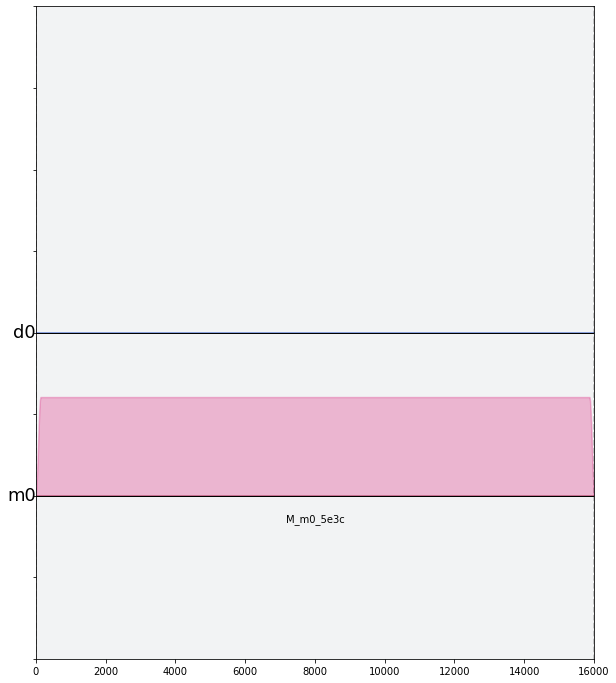

In [18]:
f0_schedule.draw(channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

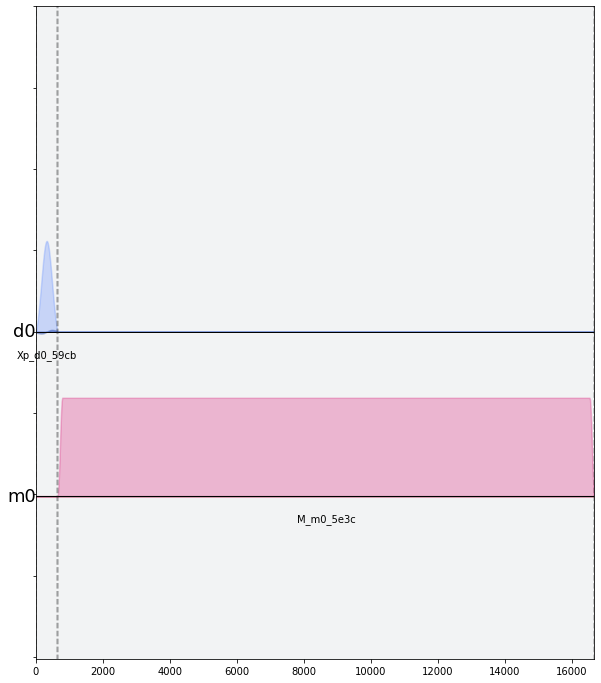

In [19]:
f1_schedule.draw(channels_to_plot=[drive_chan, meas_chan], label=True, scaling=1.0)

In [38]:
def mk_qobj(fr):
    meas_lo_freq = [fr]
    qobj = qk.assemble(
        [f0_schedule, f1_schedule], backend=backend, meas_level=1, meas_return='single',
        meas_lo_freq=meas_lo_freq, shots=512,
    )
    return qobj

In [23]:
def generate_real_data(start=0):
    results = []
    print("Frequency steps:", len(fr_steps))
    for i, fr in enumerate(fr_steps):
        if i < start:
            continue
        print(" Step:", i, fr)
        job = backend.run(mk_qobj(fr))
        result = job.result(timeout=3600)
        full_result = {
            "measurement_frequency": fr,
            "result": result,
        }
        results.append(full_result)
        with open("./xk_results/ibmq_armonk_x_and_k.{}.pickle".format(i), "wb") as f:
            pickle.dump(full_result, f)
    
    return results

In [133]:
def load_saved_data():
    results = []
    for i, fr in enumerate(fr_steps):
        with open("./xk_results/ibmq_armonk_x_and_k.{}.pickle".format(i), "rb") as f:
            full_result = pickle.load(f)
        results.append(full_result)
    return results

In [25]:
def fake_readings(f_centre, x_steps, noise=1e-6):
    """ Generate fake readings. """
    return lorentzian(x_steps, f_centre, 10., 0.5) + noise * np.random.uniform(size=x_steps.shape)

def generate_fake_data():
    f0 = fake_readings(fr - fr_delta / 2, fr_steps)
    f1 = fake_readings(fr + fr_delta / 2, fr_steps)
    return f0, f1

In [34]:
# last check before gathering data
fr, len(fr_steps), fr_steps[0], fr_steps[50], fr_steps[99]

(6.993427855, 101, 6.992427855, 6.993427855, 6.994407855)

In [134]:
r = {
    REAL_DATA: generate_real_data,
    LOAD_DATA: load_saved_data,
    FAKE_DATA: generate_fake_data,
}[data_mode]()

In [135]:
f0_single = [np.array(row['result'].results[0].data.memory)[:, 0, :] for row in r]
f0 = np.array([np.linalg.norm(np.sum(a, 0) / 512) for a in f0_single])

f1_single = [np.array(row['result'].results[1].data.memory)[:, 0, :] for row in r]
f1 = np.array([np.linalg.norm(np.sum(a, 0) / 512) for a in f1_single])

## Plot measurement response as a function of frequency

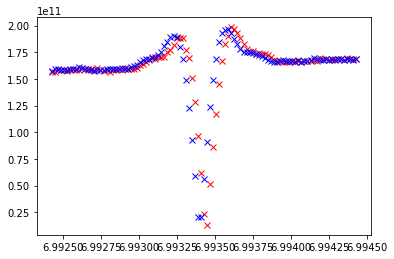

In [136]:
plt.plot(fr_steps, f0, 'rx')
plt.plot(fr_steps, f1, 'bx')

## Fit Lorentzian distribution to frequency responses

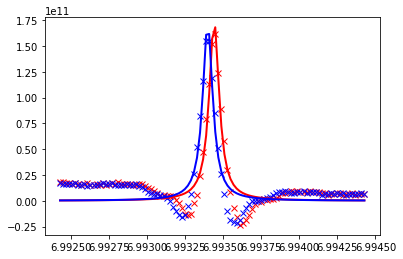

In [137]:
f0_inv = 1.75e11 - f0
f1_inv = 1.75e11 - f1

initial_fit_f0 = [fr, np.max(f0_inv), 0.001]
initial_fit_f1 = [fr, np.max(f1_inv), 0.001]

f0_fit, f0_cov_matrix = curve_fit(lorentzian, fr_steps, f0_inv, p0=initial_fit_f0, maxfev=50000)
f0_centre, f0_a, f0_gamma = f0_fit

f1_fit, f1_cov_matrix = curve_fit(lorentzian, fr_steps, f1_inv, p0=initial_fit_f1, maxfev=50000)
f1_centre, f1_a, f1_gamma = f1_fit

plt.plot(fr_steps, f0_inv, 'rx')
plt.plot(fr_steps, f1_inv, 'bx')
plt.plot(fr_steps, lorentzian(fr_steps, *f0_fit), 'r-', lw=2)
plt.plot(fr_steps, lorentzian(fr_steps, *f1_fit), 'b-', lw=2)

In [138]:
f0_centre, f1_centre, fr

(6.993440649089158, 6.993398055379468, 6.993427855)

## Determine X and K from fits

In [139]:
X = (f0_centre - f1_centre) / 2
X

2.1296854844976565e-05

In [140]:
avg_sigma = np.abs((f0_gamma + f1_gamma) / 2)
K = 2 * (2 * np.log(2)) ** 0.5 * avg_sigma  # averge FWHM
K

0.00018750528993501973